# **Introduction**

In [ ]:
# prompt: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset download this dataset and store as data folder
!pip install kaggle
# Assuming you have your kaggle.json in your Google Drive
# Replace with your actual path
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p /content/data
# Unzip the dataset
!unzip /content/data/breast-ultrasound-images-dataset.zip -d /content/data

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 89% 173M/195M [00:02<00:00, 91.8MB/s]
100% 195M/195M [00:02<00:00, 92.5MB/s]
Archive:  /content/data/breast-ultrasound-images-dataset.zip
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: /content/data/Dataset_BUSI_with_GT/benign/benign 

**About Dataset**

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning.

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

**Approach**

* **AttentionUNet/UNet** is the best know model for **Multi-Class Segmentation**, thats why we will be creating a **Attention UNet Model**.
* As the **image Dataset** is **old**, please **do not use it for any new medical operations**.
* All the images are of 500 X 500 pixels, **Kaggle RAM** wil not be enough so we will be resizing the Image to **256 X 256 pixels**.

**Model Architecture**

* The Model will consist of a **Encoder Block, Decoder Block and a Attention Gate.**

# **Imports**

In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.saving import register_keras_serializable
# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

# **Data**

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
SIZE = 256

In [ ]:
data_dir = './data/Dataset_BUSI_with_GT'
image_paths, mask_paths = [], []

for label in ['benign', 'malignant']:
    folder = os.path.join(data_dir, label)
    for file in os.listdir(folder):
        if 'mask' in file.lower():
            base_filename = os.path.splitext(file)[0]
            image_filename = base_filename.replace('_mask', '') + os.path.splitext(file)[1]
            image_path = os.path.join(folder, image_filename)
            mask_path = os.path.join(folder, file)
            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_paths.append(image_path)
                mask_paths.append(mask_path)

## **Approach**

Images with multiple mask


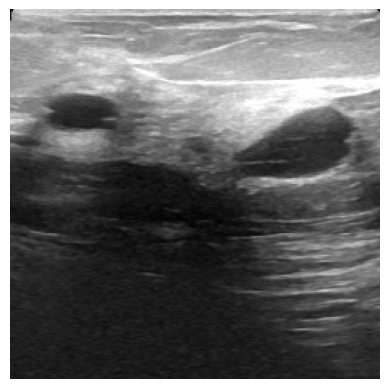

In [ ]:
show_image(load_image('./data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

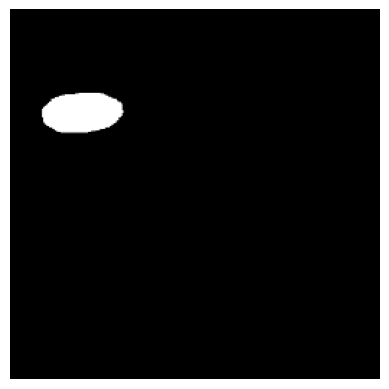

In [ ]:
show_image(load_image('./data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE))

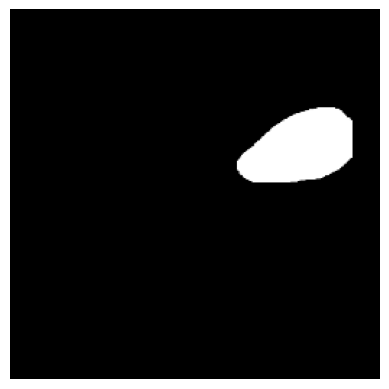

In [ ]:
show_image(load_image('./data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE))

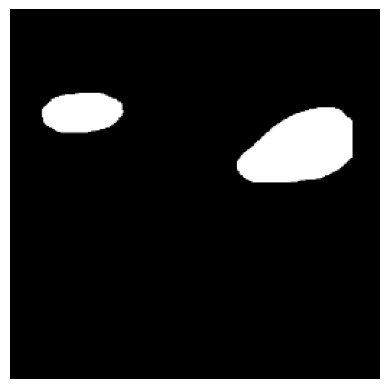

In [ ]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('./data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('./data/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

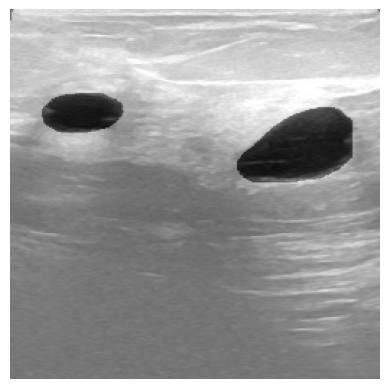

In [ ]:
show_image(load_image('./data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

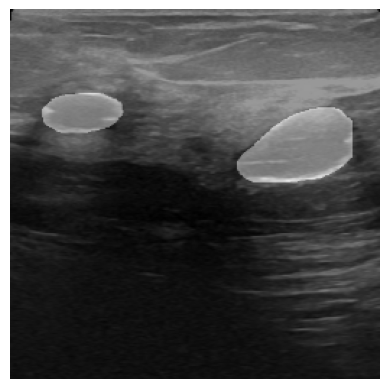

In [ ]:
show_image(load_image('./data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='gray', alpha=0.4)
plt.axis('off')
plt.show()

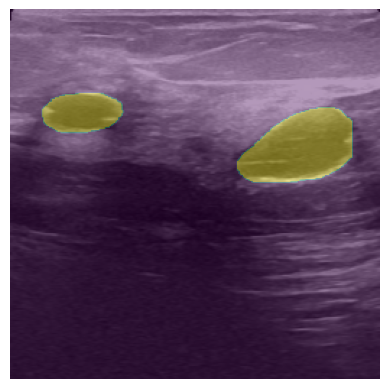

In [ ]:
show_image(load_image('./data/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.4)
plt.axis('off')
plt.show()

since less number of such cases 16 decided to drop


## **Data Work**

In [ ]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

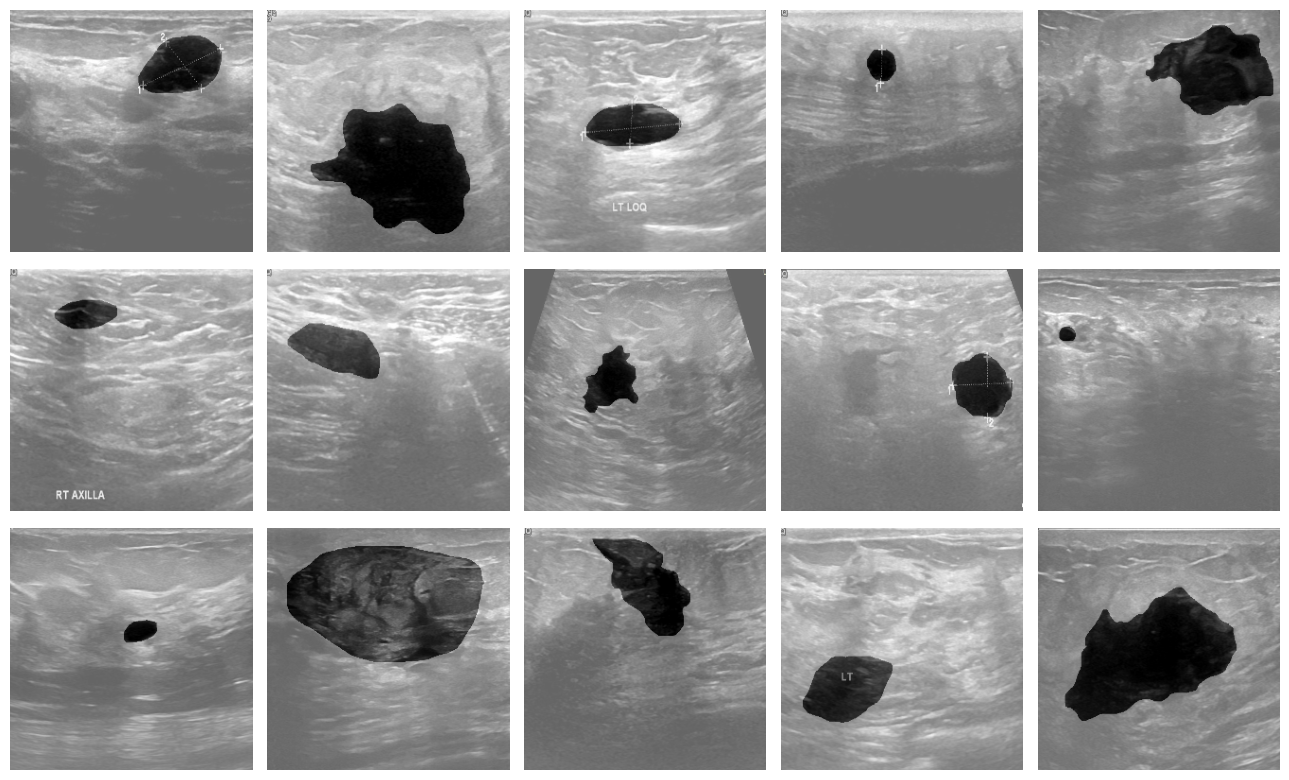

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='binary')
plt.tight_layout()
plt.show()

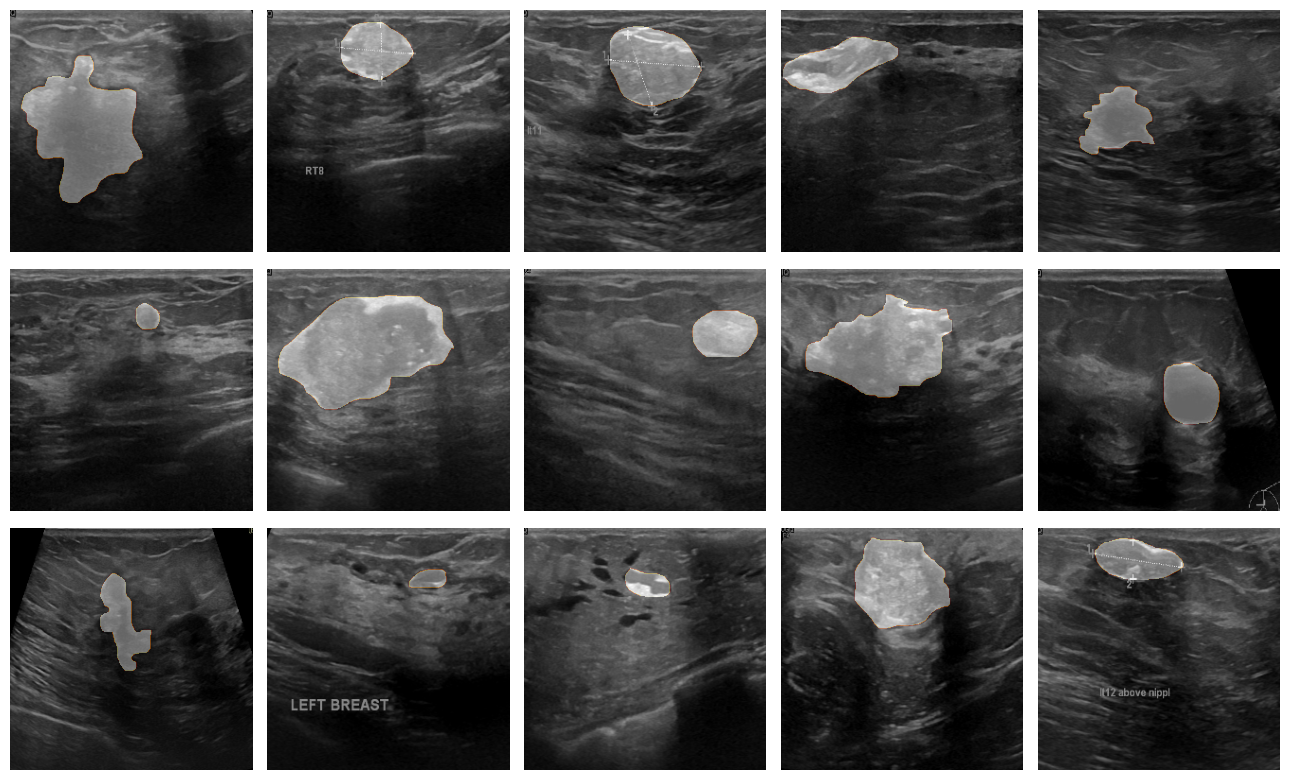

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='afmhot')
plt.tight_layout()
plt.show()

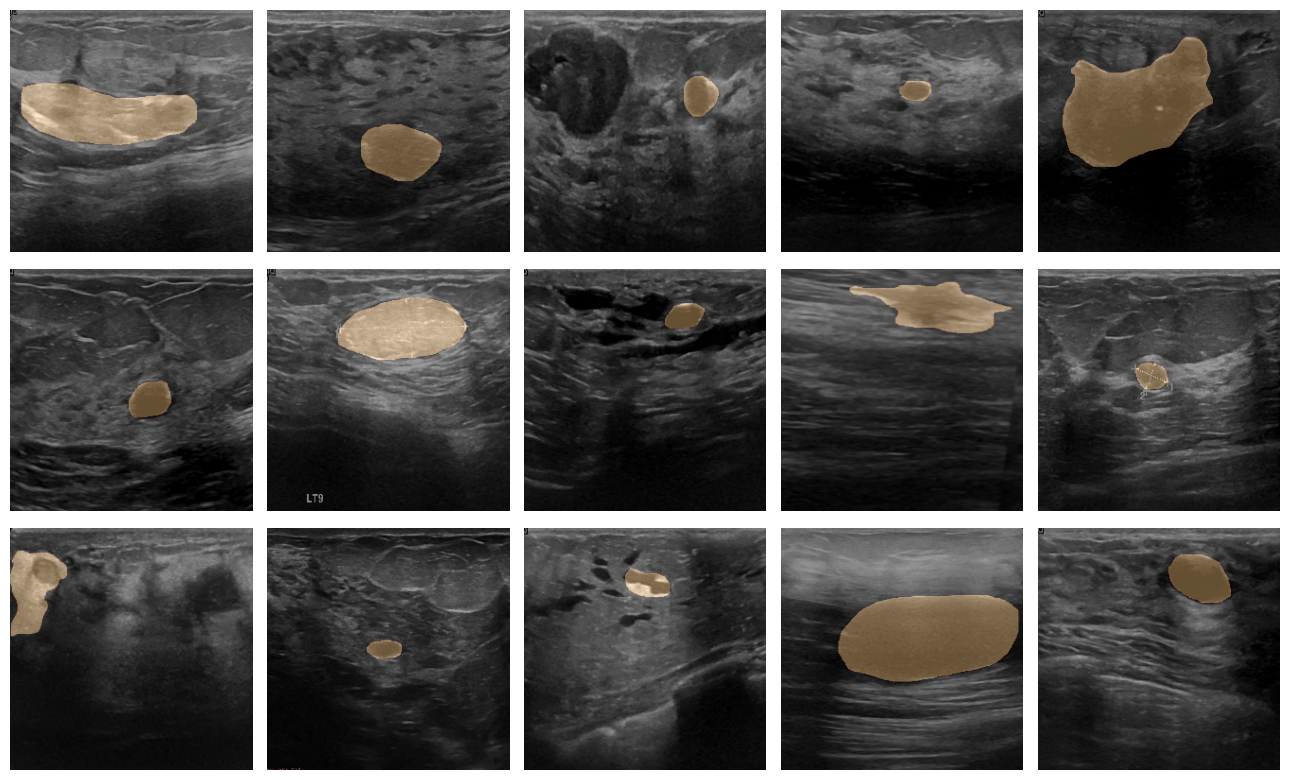

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# **Encoder**

In [ ]:
@register_keras_serializable(package="CustomLayers")
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [ ]:
@register_keras_serializable(package="CustomLayers")
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [ ]:
@register_keras_serializable(package="CustomLayers")
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Attention UNet**

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'Encoding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_block_1', however the layer does n

# **Training**

In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=20, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,

)

Epoch 1/20
65/80 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - IoU: 0.4524 - accuracy: 0.9300 - loss: 0.1926

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - IoU: 0.4485 - accuracy: 0.9298 - loss: 0.1937 - val_IoU: 0.4284 - val_accuracy: 0.8531 - val_loss: 0.3803
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - IoU: 0.4509 - accuracy: 0.9345 - loss: 0.1831 - val_IoU: 0.4284 - val_accuracy: 0.8531 - val_loss: 0.3634
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - IoU: 0.4457 - accuracy: 0.9236 - loss: 0.2130 - val_IoU: 0.4284 - val_accuracy: 0.8560 - val_loss: 0.3304
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - IoU: 0.4500 - accuracy: 0.9351 - loss: 0.1831 - val_IoU: 0.4284 - val_accuracy: 0.8605 - val_loss: 0.3125
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - IoU: 0.4462 - accuracy: 0.9303 - loss: 0.1855 - val_IoU: 0.4284 - val_accuracy: 0.8667 - val_loss: 0.3033
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - IoU: 0.4500 - accuracy: 0.9340 - loss: 0.1827 - val_IoU: 0.4284 - val_accuracy: 0.8614 - val_loss: 0.3332
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 176

# **Evaluation**

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

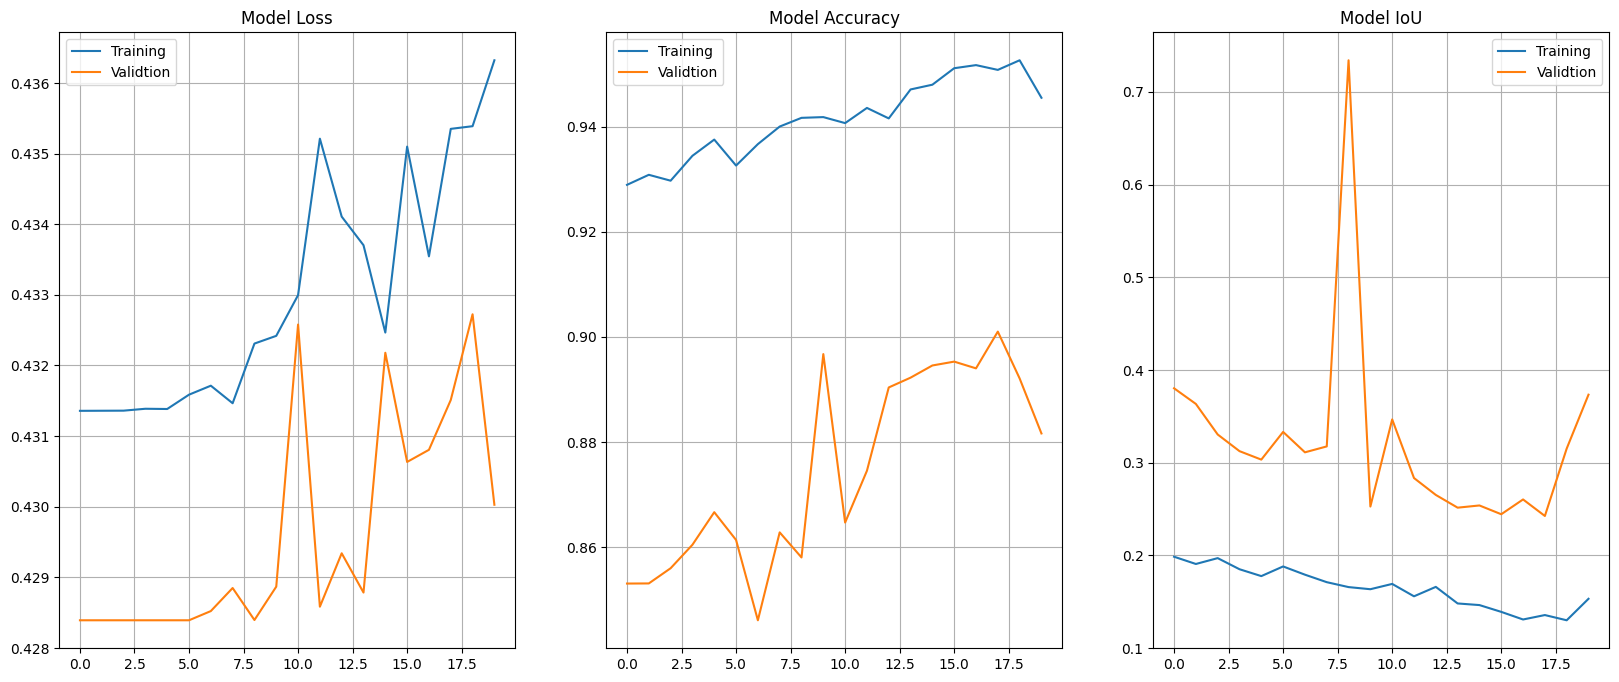

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


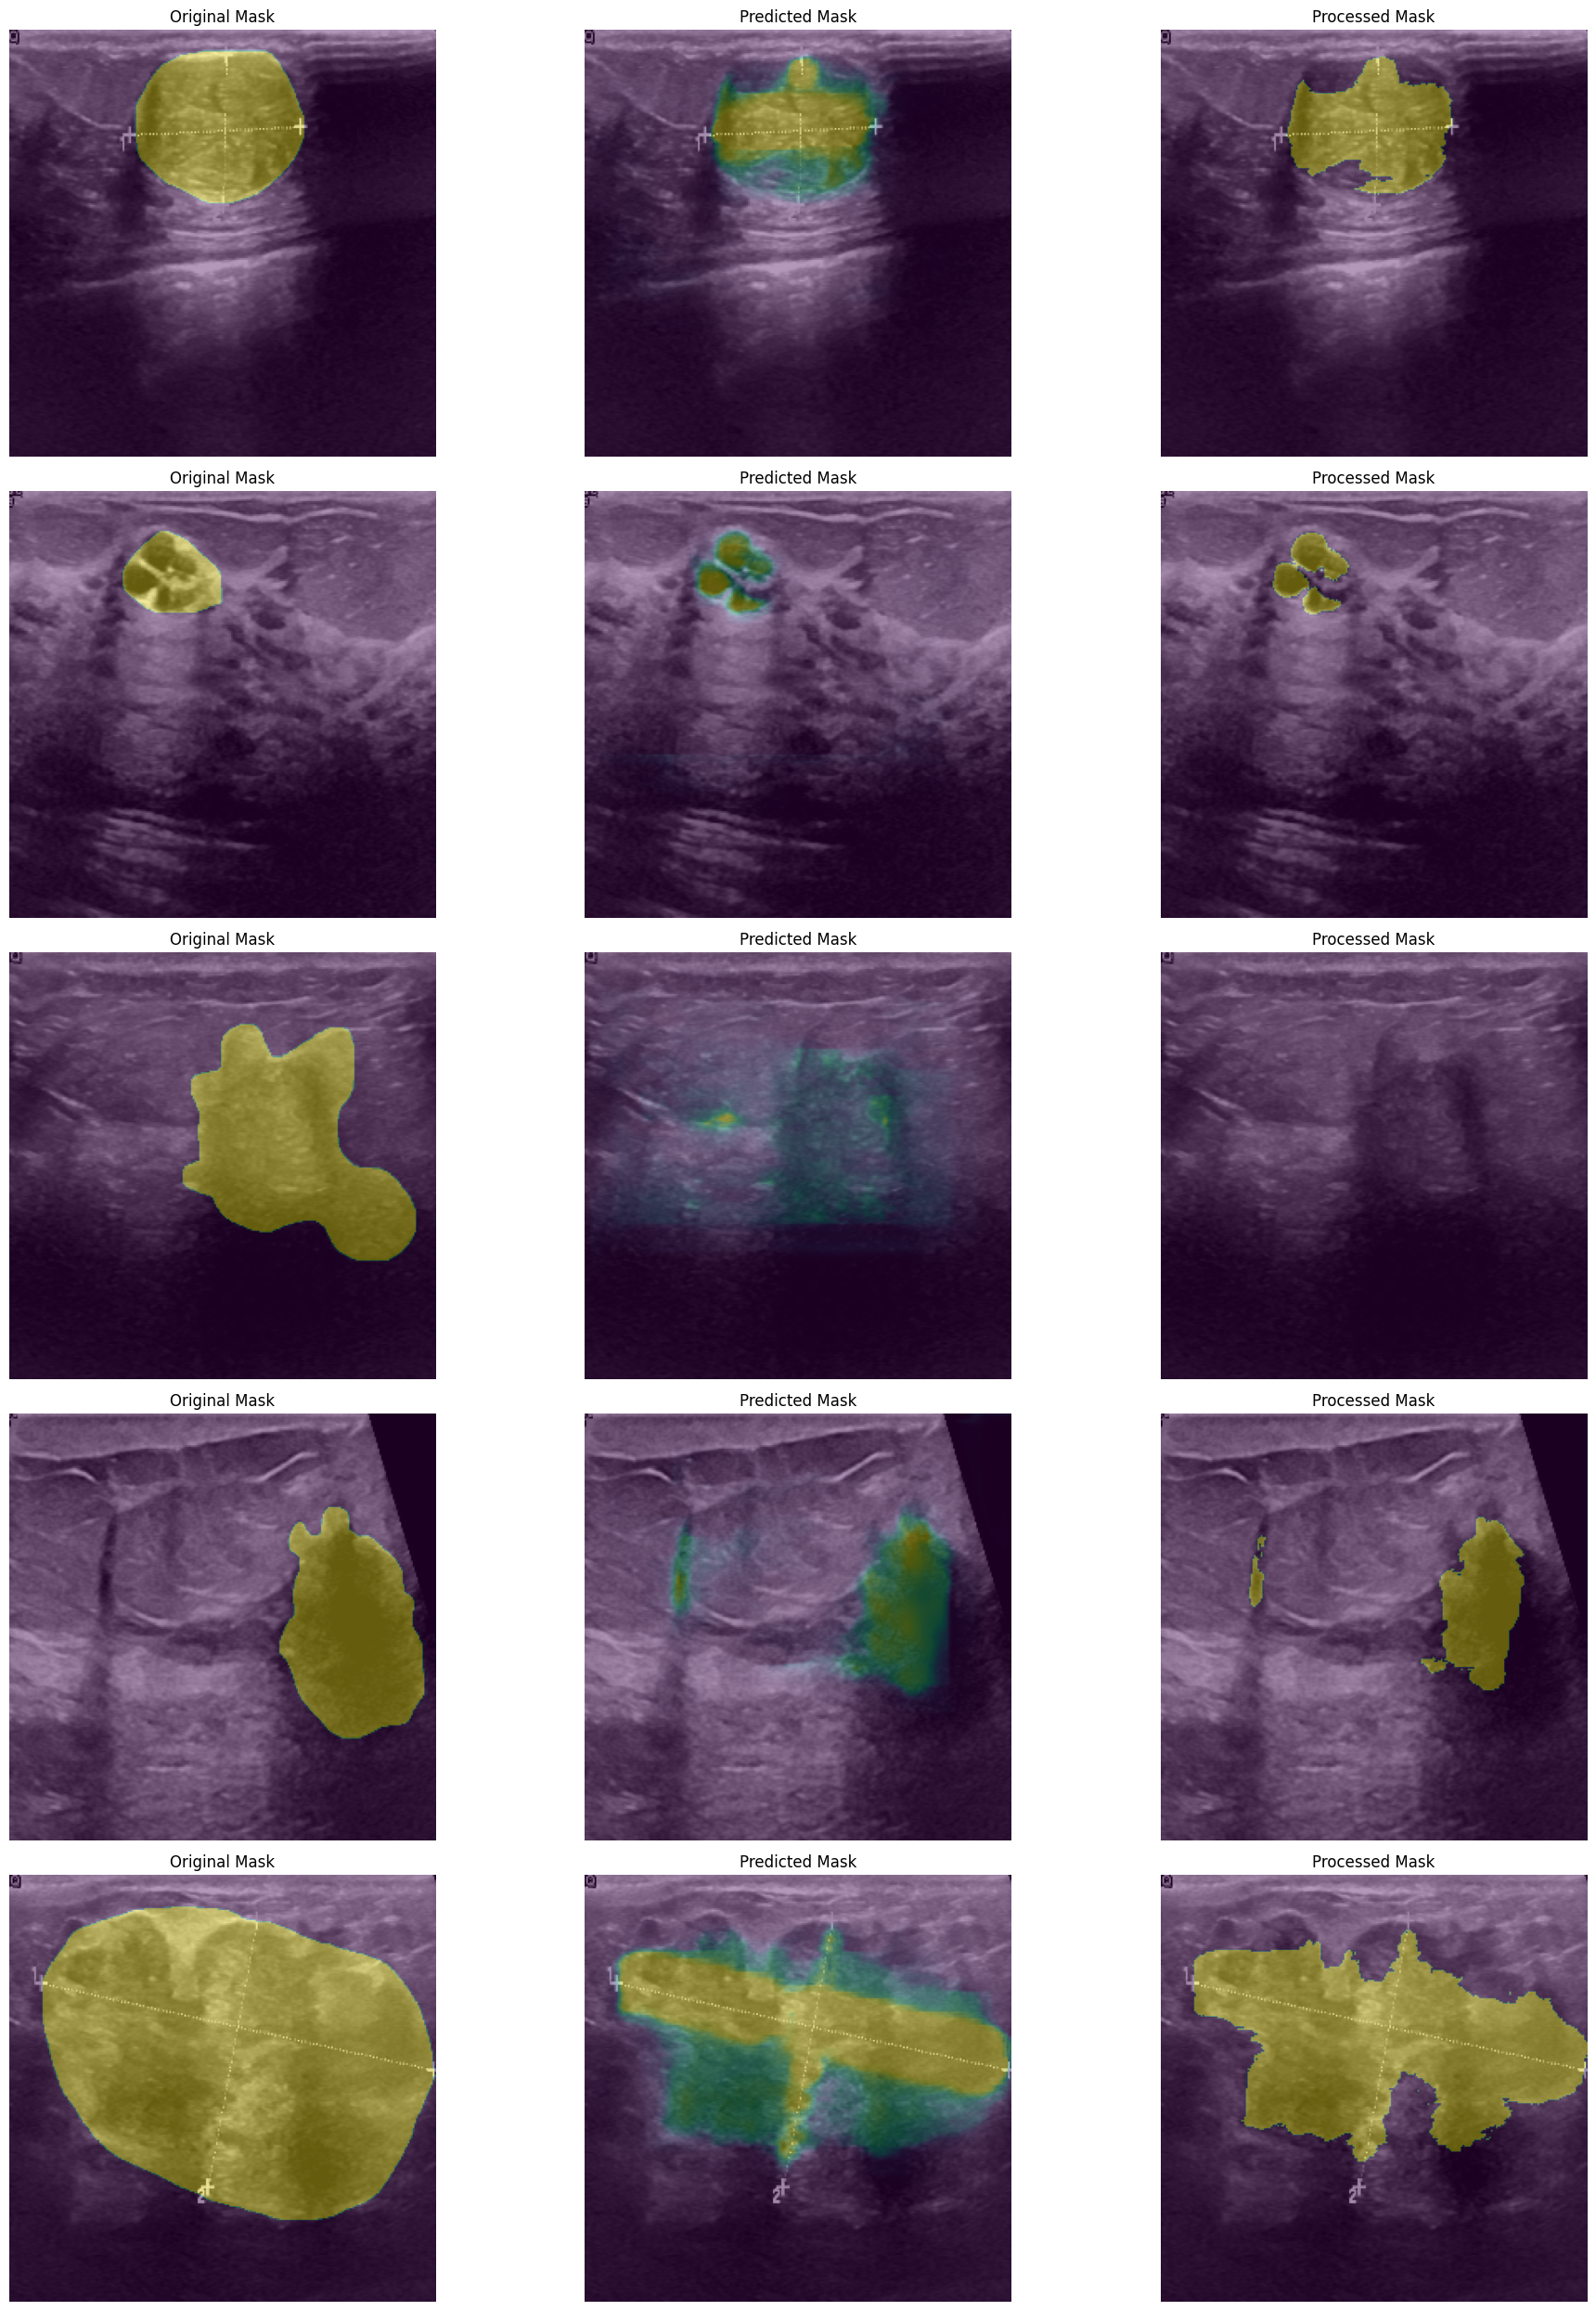

In [ ]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
files.download('AttentionCustomUNet.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>